## Final Model parameters selection

In [47]:
# Data Handling
import pandas as pd
import numpy as np

# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

# Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: To suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [48]:
import plotly.express as px


In [49]:
# Load the dataset
df = pd.read_csv("C:/Users/vpotla/Desktop/Testing-SQL-Server/new-data2.csv")

# View first few rows
print(df.head())

  ServerName DatabaseName  Size_Used  Year  Month  Growth%
0    Server1          DB1       80.0  2021      1   0.1142
1    Server1          DB1       56.0  2021      2   0.0800
2    Server1          DB1       62.0  2021      3   0.0885
3    Server1          DB1      236.0  2021      4   0.3371
4    Server1          DB1      256.0  2021      5   0.3657


In [50]:
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str) + "-01")
df = df.sort_values("Date")

In [51]:
df.set_index("Date")

,ServerName,DatabaseName,Size_Used,Year,Month,Growth%
Date,,,,,,
2020-08-01,Server1,DB3,38.0,2020,8,0.0542
2020-09-01,Server1,DB3,197.0,2020,9,0.2814
2020-10-01,Server1,DB3,108.0,2020,10,0.1542
2020-11-01,Server1,DB3,104.0,2020,11,0.1485
2020-12-01,Server1,DB3,205.0,2020,12,0.2928
...,...,...,...,...,...,...
2025-08-01,Server1,DB3,197.0,2025,8,0.2814
2025-08-01,Server1,DB2,85.0,2025,8,0.1214
2025-08-01,Server1,DB1,586.0,2025,8,0.8371


In [52]:
group = df.groupby("Date")["Growth%"].mean().reset_index()
group = group.set_index("Date").asfreq("MS")  # monthly series
group["Growth%"] = group["Growth%"].fillna(method="ffill")

In [53]:
group.head(15)

,Growth%
Date,
2020-08-01,0.054200
2020-09-01,0.281400
2020-10-01,0.154200
2020-11-01,0.148500
2020-12-01,0.292800
2021-01-01,0.138300
2021-02-01,0.188567
2021-03-01,0.231600
2021-04-01,0.340683


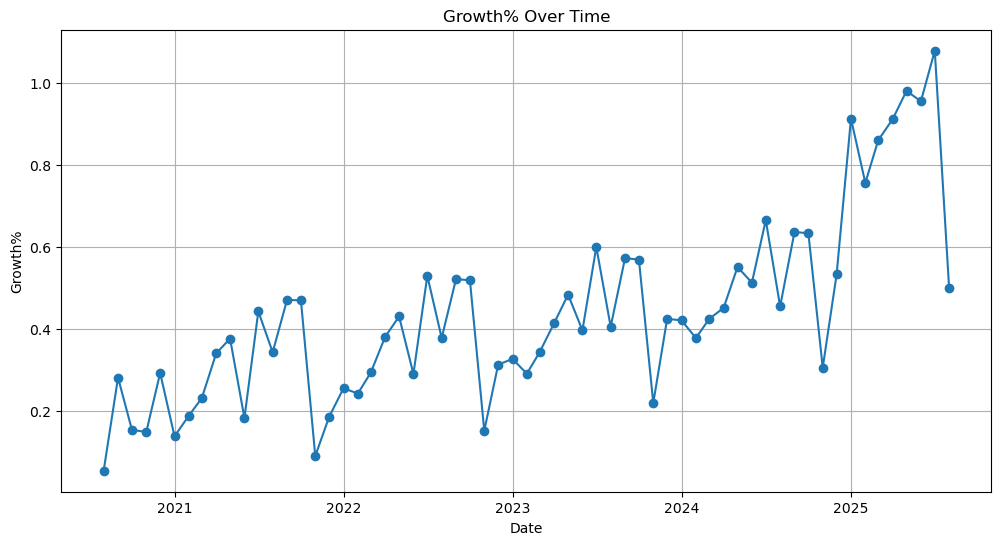

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(group.index, group['Growth%'], marker='o', linestyle='-')
plt.title("Growth% Over Time")
plt.xlabel("Date")
plt.ylabel("Growth%")
plt.grid(True)
plt.show()


## Decomposition

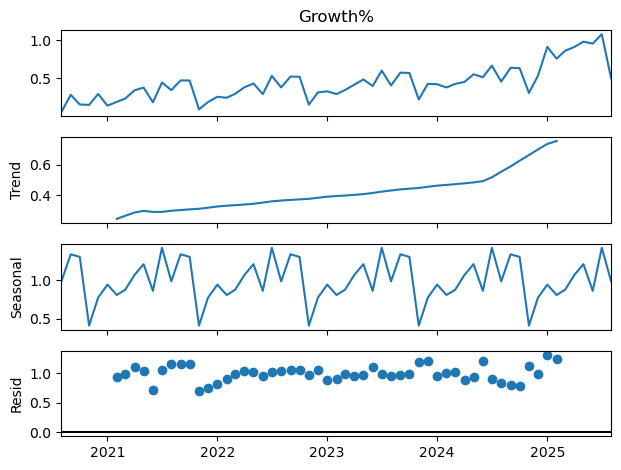

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
result = seasonal_decompose(group['Growth%'], model='multiplicative', period=12)  
# period=12 for monthly data with yearly seasonality

# Plot decomposition
result.plot()
plt.show()


In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(group['Growth%'], model='multiplicative', period=12)

# Extract individual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Display first few values
print("Trend:\n", trend.head(12))
print("\nSeasonality:\n", seasonal.head(12))
print("\nResiduals:\n", residual.head(12))


Trend:
 Date
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
2020-11-01         NaN
2020-12-01         NaN
2021-01-01         NaN
2021-02-01    0.248108
2021-03-01    0.268049
2021-04-01    0.289111
2021-05-01    0.299838
2021-06-01    0.292947
2021-07-01    0.293373
Freq: MS, Name: trend, dtype: float64

Seasonality:
 Date
2020-08-01    0.985667
2020-09-01    1.337234
2020-10-01    1.303023
2020-11-01    0.410607
2020-12-01    0.773989
2021-01-01    0.943152
2021-02-01    0.808503
2021-03-01    0.876277
2021-04-01    1.069036
2021-05-01    1.208755
2021-06-01    0.862021
2021-07-01    1.421736
Freq: MS, Name: seasonal, dtype: float64

Residuals:
 Date
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
2020-11-01         NaN
2020-12-01         NaN
2021-01-01         NaN
2021-02-01    0.940034
2021-03-01    0.986012
2021-04-01    1.102285
2021-05-01    1.039187
2021-06-01    0.724018
2021-07-01    1.062178
Freq: MS, Name: resid, dtype: float64


## Checking Stationarity

In [60]:
#considering trend+Constant for checking the Stationarity
from statsmodels.tsa.stattools import adfuller

adf_result=adfuller(group,regression='ct')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Number of lags used: {adf_result[2]}")

ADF Statistic: 1.2035468539684198
p-value: 1.0
Number of lags used: 11


In [61]:
#WIll not capture Trend , so it is showing data is not stationary


from statsmodels.tsa.stattools import adfuller

# Run the test on your time series
adf_result = adfuller(group['Growth%'])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("Series is Stationary (reject H0)")
else:
    print("Series is NOT Stationary (fail to reject H0)")


ADF Statistic: 2.4582030552237946
p-value: 0.999035119746371
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153
Series is NOT Stationary (fail to reject H0)


In [65]:
#considering trend+Constant for checking the Stationarity
from statsmodels.tsa.stattools import adfuller

adf_result=adfuller(group.diff().diff().dropna(),regression='ct')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Number of lags used: {adf_result[2]}")

ADF Statistic: -5.2564748189662645
p-value: 6.844457274103606e-05
Number of lags used: 11


In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

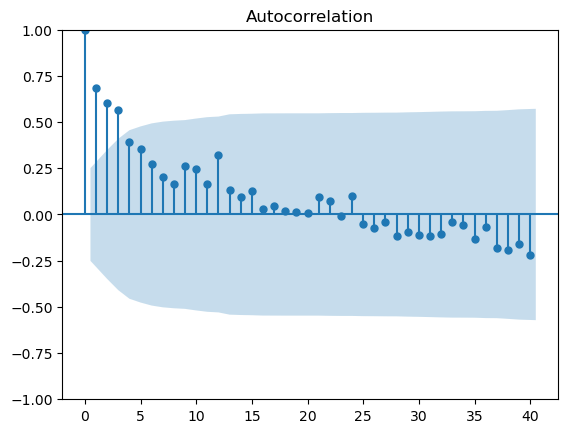

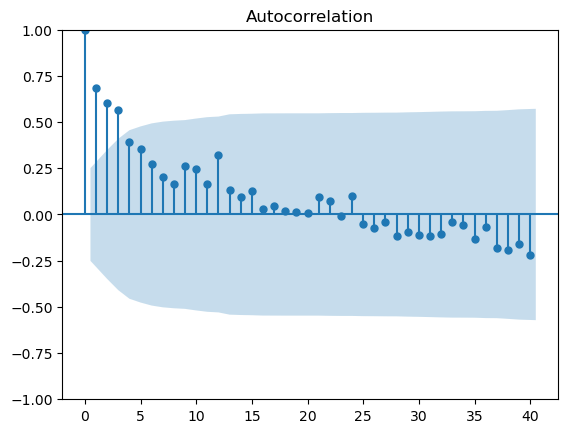

In [67]:
plot_acf(group,alpha=0.05,lags=40)   #alpha = significance level for the confidence interval.

In [68]:
q=3

In [69]:
d=2

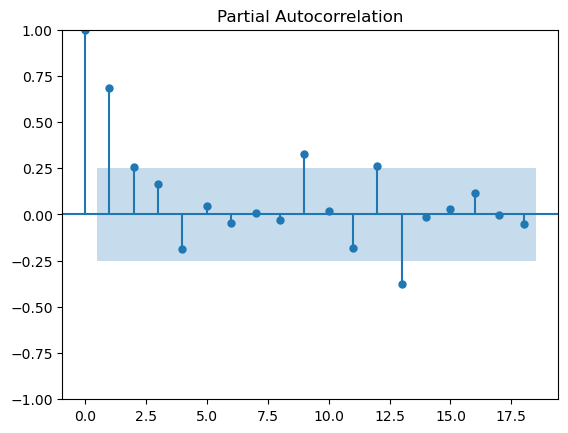

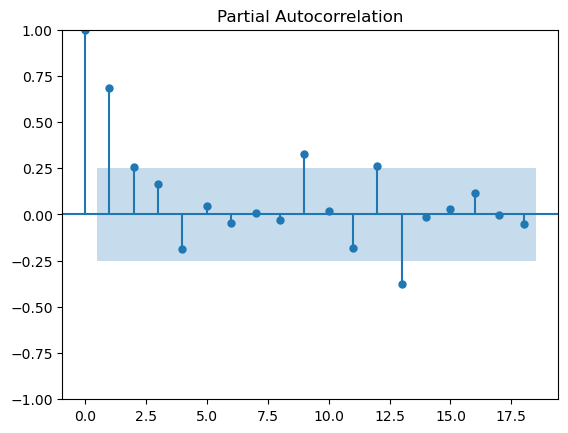

In [70]:
plot_pacf(group, alpha=0.05)

In [71]:
p=1

### Model Building

In [72]:
train=group[group.index<='2024']
test=group[group.index>'2024']

In [73]:
print(train.shape)
print(test.shape)

(42, 1)
(19, 1)


<Axes: xlabel='Date'>

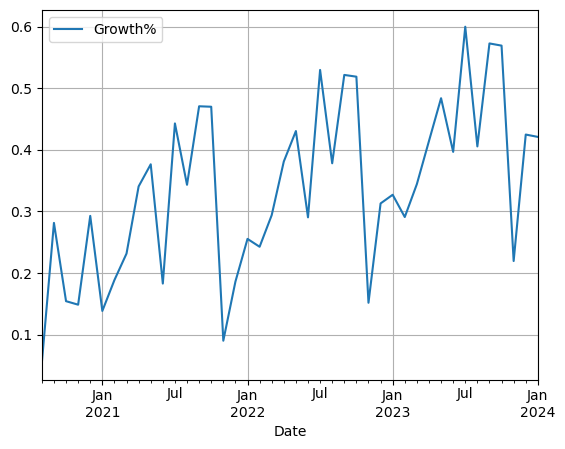

In [74]:
train.plot(grid=True)

In [75]:
adf_result=adfuller(train,regression='ct')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Number of lags used: {adf_result[2]}")

ADF Statistic: -7.036596641405918
p-value: 1.1675489967415648e-08
Number of lags used: 10


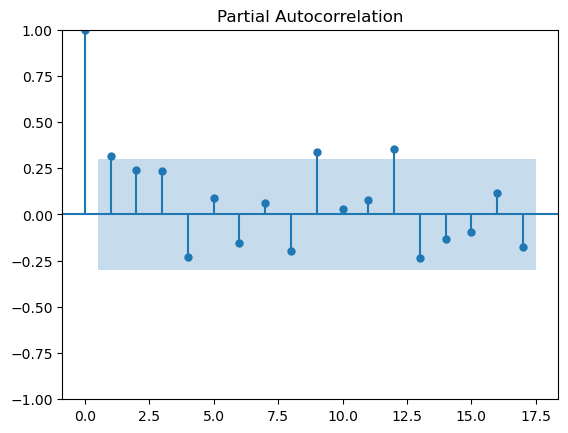

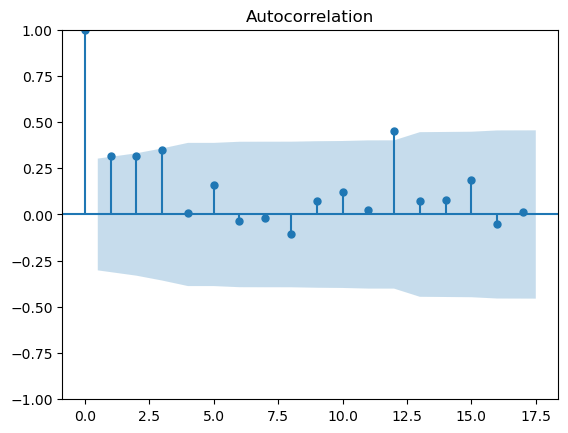

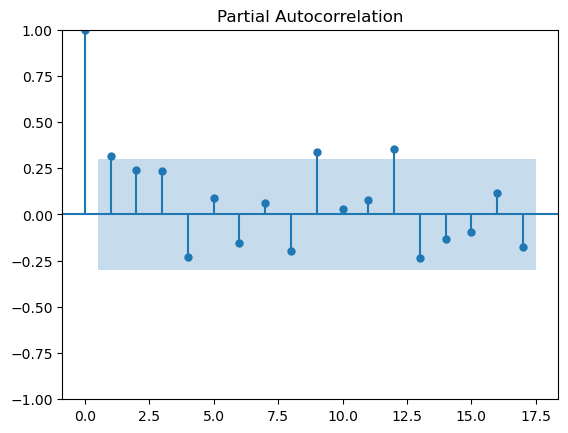

In [76]:
plot_acf(train,alpha=0.05)
plot_pacf(train,alpha=0.05)

In [137]:
from statsmodels.tsa.arima.model import ARIMA
# order=(7,1,6)
# Fit ARIMA model
model = ARIMA(group, order=(12,1,6))
model_fit = model.fit()

# Model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Growth%   No. Observations:                   61
Model:                ARIMA(12, 1, 6)   Log Likelihood                  55.896
Date:                Wed, 27 Aug 2025   AIC                            -73.792
Time:                        16:54:07   BIC                            -34.000
Sample:                    08-01-2020   HQIC                           -58.227
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3520      0.420     -0.839      0.402      -1.175       0.471
ar.L2         -0.4500      0.363     -1.239      0.215      -1.162       0.262
ar.L3         -0.3608      0.373     -0.968      0.3

In [138]:
# Forecast for next 6 months (adjust steps as needed)
forecast = model_fit.forecast(steps=len(test))
print("Forecasted Values:\n", forecast)


Forecasted Values:
 2025-09-01    0.650929
2025-10-01    0.764463
2025-11-01    0.425575
2025-12-01    0.565924
2026-01-01    0.863789
2026-02-01    0.710879
2026-03-01    0.869134
2026-04-01    0.885473
2026-05-01    0.866956
2026-06-01    0.820368
2026-07-01    0.937705
2026-08-01    0.431938
2026-09-01    0.567197
2026-10-01    0.783556
2026-11-01    0.532780
2026-12-01    0.626143
2027-01-01    0.905510
2027-02-01    0.764982
2027-03-01    0.907708
Freq: MS, Name: predicted_mean, dtype: float64


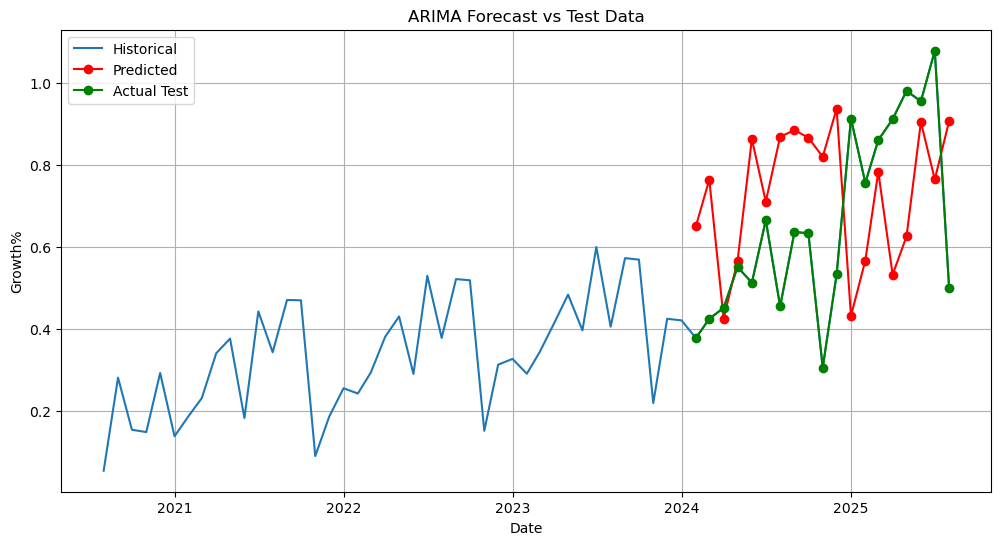

In [139]:
# 4. Plot Historical, Test, and Forecast
plt.figure(figsize=(12,6))
plt.plot(group.index, group['Growth%'], label='Historical')
plt.plot(test.index, forecast, color='red', marker='o', label='Predicted')
plt.plot(test.index, test, color='green', marker='o', label='Actual Test')
plt.title("ARIMA Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("Growth%")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
# Store in list
list ={
    "Order": (12,1,6),
    "RMSE": rmse,
    "MAE": mae
                }
metrics_list.append(list)

print(metrics_list)


[{'Order': (7, 1, 6), 'RMSE': 0.27531502282073483, 'MAE': 0.2385006269286489}, {'Order': (1, 0, 6), 'RMSE': 0.40331087157165263, 'MAE': 0.3366801972703087}, {'Order': (11, 1, 1), 'RMSE': 0.31989102920403145, 'MAE': 0.23671604306999308}, {'Order': (12, 2, 12), 'RMSE': 6.828132451234537, 'MAE': 5.956355283291861}, {'Order': (9, 2, 3), 'RMSE': 0.3513401203021828, 'MAE': 0.2920998232844604}, {'Order': (1, 2, 3), 'RMSE': 0.3479436170704375, 'MAE': 0.2968120666576884}, {'Order': (9, 2, 12), 'RMSE': 0.28046721171787964, 'MAE': 0.22933934110628598}, {'Order': (9, 1, 12), 'RMSE': 0.3805085792743478, 'MAE': 0.30652414512300036}, {'Order': (9, 2, 11), 'RMSE': 0.3856599451175875, 'MAE': 0.3075636193701288}, {'Order': (8, 3, 8), 'RMSE': 0.31426456400827274, 'MAE': 0.25197574752014956}, {'Order': (8, 2, 8), 'RMSE': 0.3725408911347107, 'MAE': 0.3123880428215119}, {'Order': (12, 1, 6), 'RMSE': 0.3114869110785022, 'MAE': 0.2694358632659809}]


In [91]:

# ---------------------------
# Select Best ARIMA per series
# ---------------------------
def select_best_arima(ts, p_range=(0,12), d_range=(0,4), q_range=(0,12)):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in range(*p_range):
        for d in range(*d_range):
            for q in range(*q_range):
                try:
                    model = ARIMA(ts, order=(p,d,q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue
    return best_model, best_order, best_aic

In [97]:
best_model, best_order, best_bic = select_best_arima(train, p_range=(0, 12), d_range=(0, 3), q_range=(0, 12))
print(f"Best ARIMA order={best_order}, AIC={best_aic}")
    
# Forecast on test set
forecast = best_model.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f"Test MSE={mse}, MAE={mae}")

Best ARIMA order=(11, 1, 1), AIC=-109.08075471829665
Test MSE=0.10233027056521449, MAE=0.23671604306999308


In [98]:
rmse = np.sqrt(mean_squared_error(test, forecast))
# Store in list
list ={
    "Order": best_order,
    "RMSE": rmse,
    "MAE": mae
                }
metrics_list.append(list)

print(metrics_list)


[{'Order': (7, 1, 6), 'RMSE': 0.27531502282073483, 'MAE': 0.2385006269286489}, {'Order': (1, 0, 6), 'RMSE': 0.40331087157165263, 'MAE': 0.3366801972703087}, {'Order': (11, 1, 1), 'RMSE': 0.31989102920403145, 'MAE': 0.23671604306999308}]


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [120]:
# SARIMA Model (example parameters)
order = (1,1,2)
seasonal_order = (0, 1, 0, 12)  # Example seasonal order (P, D, Q, s)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             Growth%   No. Observations:                   42
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 12)   Log Likelihood                  32.918
Date:                             Tue, 26 Aug 2025   AIC                            -57.836
Time:                                     15:46:18   BIC                            -52.367
Sample:                                 08-01-2020   HQIC                           -56.123
                                      - 01-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3941      0.239     -1.646      0.100      -0.863       0.075
ma.L1          0.1040      

In [121]:
# Forecast
predictions = model_fit.forecast(len(test))
print("Forecasted Values:\n", forecast)

Forecasted Values:
 2025-09-01    0.514699
2025-10-01    0.637851
2025-11-01    0.314200
2025-12-01    0.571588
2026-01-01    0.484051
2026-02-01    0.435948
2026-03-01    0.596556
2026-04-01    0.579884
2026-05-01    0.547283
2026-06-01    0.513998
2026-07-01    0.651389
2026-08-01    0.309664
2026-09-01    0.457749
2026-10-01    0.581249
2026-11-01    0.263708
2026-12-01    0.565037
2027-01-01    0.480591
2027-02-01    0.409124
2027-03-01    0.581655
Freq: MS, Name: predicted_mean, dtype: float64


In [122]:

# Evaluation
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
# Store in list
list = [{
    "Order": ((1,1,2),(0, 1, 0, 12)),
    "RMSE": rmse,
    "MAE": mae
}]
metrics_list_sarima.append(list)
print(metrics_list_sarima)

[{'Order': ((7, 1, 6), (1, 1, 1, 12)), 'RMSE': 0.08044940696905596, 'MAE': 0.04826800592993212}, [{'Order': ((1, 1, 1), (1, 1, 1, 12)), 'RMSE': 0.0723514654639391, 'MAE': 0.0441871661314857}], [{'Order': ((1, 0, 3), (1, 1, 1, 12)), 'RMSE': 0.0648776186313891, 'MAE': 0.036177764879604536}], [{'Order': ((1, 1, 2), (0, 1, 0, 12)), 'RMSE': 0.0658967797882425, 'MAE': 0.03336064734970958}]]


In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# Example data (replace with your time series)
y = train

# Parameter ranges
p = [0, 1,2,3]
d = [0, 1,2]
q = [0, 1,2,3]
P = [0, 1,2]
D = [0, 1]
Q =  [0,1]
s = [12]  # Seasonal period

best_aic = float("inf")
best_params = None
best_seasonal_params = None

# Loop through all combinations
for i in p:
    for j in d:
        for k in q:
            for si in P:
                for sj in D:
                    for sk in Q:
                        for ss in s:
                            try:
                                model = sm.tsa.statespace.SARIMAX(
                                    y,
                                    order=(i, j, k),
                                    seasonal_order=(si, sj, sk, ss),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                )
                                results = model.fit(disp=False)
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_params = (i, j, k)
                                    best_seasonal_params = (si, sj, sk, ss)
                            except:
                                continue

print(f"Best SARIMA order: {best_params}, Seasonal order: {best_seasonal_params}")
print(f"Best AIC: {best_aic}")


Best SARIMA order: (1, 1, 2), Seasonal order: (0, 1, 0, 12)
Best AIC: -109.08075471829665


In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# Example data (replace with your actual training data)
y = train

# Parameter ranges
p = [0, 1, 2, 3]
d = [0, 1, 2]
q = [0, 1, 2, 3]
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1]
s = [12]  # Seasonal period

best_aic = float("inf")
best_params = None
best_seasonal_params = None
best_model_fit = None

# Loop through all combinations
for i in p:
    for j in d:
        for k in q:
            for si in P:
                for sj in D:
                    for sk in Q:
                        for ss in s:
                            try:
                                model = sm.tsa.statespace.SARIMAX(
                                    y,
                                    order=(i, j, k),
                                    seasonal_order=(si, sj, sk, ss),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                )
                                results = model.fit(disp=False)
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_params = (i, j, k)
                                    best_seasonal_params = (si, sj, sk, ss)
                                    best_model_fit = results
                            except:
                                continue

# Predictions on training data (in-sample fit)
y_pred = best_model_fit.fittedvalues

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"Best SARIMA order: {best_params}, Seasonal order: {best_seasonal_params}")
print(f"Best AIC: {best_aic}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Best SARIMA order: (1, 1, 2), Seasonal order: (0, 1, 0, 12)
Best AIC: -109.08075471829665
RMSE: 0.10465439754499584
MAE: 0.06374656787391049


In [36]:
import joblib

def save_model_metadata(model, order, seasonal_order, aic, rmse, mae, filename="best_sarima_model_meta.pkl"):
    metadata = {
        "order": order,                    # (p, d, q)
        "seasonal_order": seasonal_order,  # (P, D, Q, s)
        "aic": aic,
        "rmse": rmse,
        "mae": mae,
        "params": model.params.to_dict()  # save only coefficients
    }
    joblib.dump(metadata, filename)
    print(f"Model metadata saved as {filename}")


In [37]:
save_model_metadata(best_model_fit,best_params,best_seasonal_params,best_aic,rmse,mae)

Model metadata saved as best_sarima_model_meta.pkl


In [92]:
model, order, aic = select_best_arima(train,p_range=(0,7),)
forecast = model.forecast(steps=len(test))
    
if len(test) > 0:
        pred_test = model.forecast(steps=len(test))
        mse = mean_squared_error(test, pred_test)
        mae = mean_absolute_error(test, pred_test)
else:
        mse = mae = None

In [93]:
print(order)

(11, 1, 1)


In [94]:
print(np.sqrt(mse),mae,aic)

0.31989102920403145 0.23671604306999308 -61.252703467361584


In [141]:
from pmdarima import auto_arima

def load_best_arima_model(series=None):
    model = auto_arima(series,
                       seasonal=False,
                       stepwise=True,
                       suppress_warnings=True,
                       error_action="ignore")
    final_fit = model.fit(series)
    return final_fit


In [143]:
load_best_arima_model(group)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)